**Prática de Segmentação de imagens**

In [3]:
# code here
import cv2
import matplotlib.pyplot as plt
import numpy as np

1) Faça a plotagem do histograma da imagem, observando o histograma, escolha um valor para definir um threshold

(array([[  0.,   7.,  37., ...,  30.,  20., 560.],
        [  0.,   7.,  27., ...,  30.,  20., 549.],
        [  0.,   8.,  26., ...,  30.,  21., 550.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0., 900.],
        [  0.,   0.,   0., ...,   0.,   0., 900.],
        [  0.,   0.,   0., ...,   0.,   0., 900.]]),
 array([ 86. , 102.9, 119.8, 136.7, 153.6, 170.5, 187.4, 204.3, 221.2,
        238.1, 255. ]),
 <a list of 1200 BarContainer objects>)

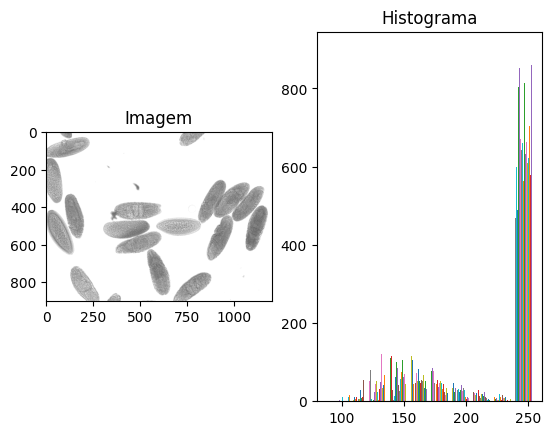

In [4]:
img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.title("Imagem")
plt.imshow(img1, cmap='gray', vmin=0, vmax=255);

plt.subplot(1,2,2)
plt.title("Histograma")
plt.hist(img1)

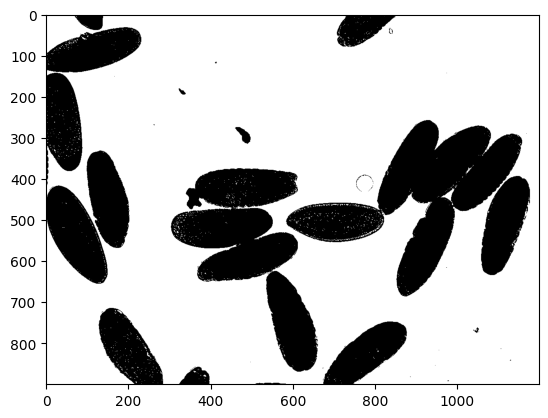

In [6]:
# observando o histograma, o melhor valor aparente de thr é 240, já que está localizado bem na divisão entre os dois picos.

img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

imH = img1.shape[0]
imW = img1.shape[1]
thr = 240

for i in range(0, imH):
    for j in range(0, imW):
        img1[i,j] = 0 if(img1[i,j] < thr) else 255

plt.imshow(img1, cmap='gray', vmin=0, vmax=255)


2)	Segmentação utilizando a técnica de Threshold Adaptativo (implementar o algortimo). Faça a aplicação do Threshold com e sem suavização prévia

Result after 3 iterations:


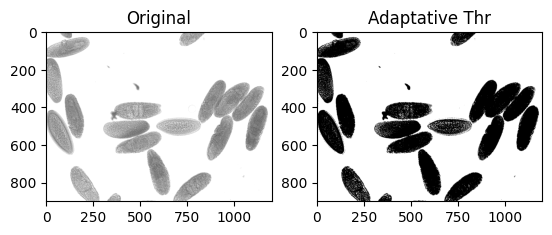

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def segmentImage(originalImage, imageOut, imgWidth, imgHeight, thr):
    for i in range(0, imgHeight):
        for j in range(0, imgWidth):
            imageOut[i,j] = 0 if(originalImage[i,j] <=thr) else 255

def calculateGroupsAverage(originalImage, segmentedImage, imgWidth, imgHeight):
    g1Sum = 0
    g1Count = 0
    
    g2Sum = 0
    g2Count = 0

    for i in range(0, imgHeight):
        for j in range(0, imgWidth):
            if(segmentedImage[i,j] == 0):
                g1Sum = g1Sum + originalImage[i,j]
                g1Count += 1
            else:
                g2Sum = g2Sum + originalImage[i,j]
                g2Count += 1
    g1Avg = g1Sum/g1Count
    g2Avg = g2Sum/g2Count
    
    return {"g1": g1Avg, "g2": g2Avg}

img1 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)

imgH = img1.shape[0]
imgW = img1.shape[1]

imOut = np.zeros((imgH, imgW))
estimateT = np.average([np.min(img1), np.max(img1)])

segmentImage(originalImage=img1, imageOut=imOut, imgWidth=imgW, imgHeight=imgH, thr=estimateT)
currentT = estimateT
newT = currentT
iterCounter = 0
while True:
    iterCounter = iterCounter + 1
    groupsAvg = calculateGroupsAverage(img1, segmentedImage=imOut, imgWidth=imgW, imgHeight=imgH)
    currentT = newT
    newT = (groupsAvg["g1"] + groupsAvg["g2"])/2
    delta = 2
    if((newT-currentT) <= delta):
        break
    segmentImage(originalImage=img1, imageOut=imOut, imgWidth=imgW, imgHeight=imgH, thr=newT)

print("Result after",iterCounter, "iterations:")
plt.subplot(1,2,2)
plt.title("Adaptative Thr")
plt.imshow(imOut, cmap='gray', vmin=0, vmax=255)

Result after 4 iterations:


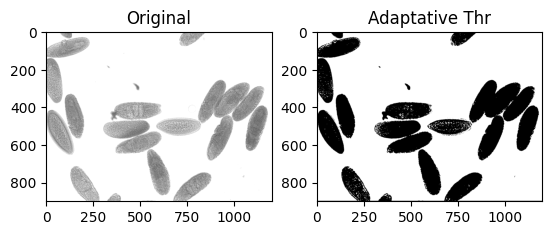

In [7]:
# Aplicação com suavização prévia

def smoothWithAvg(image, width, height):
    out = np.zeros((height,width))
    for i in range(1,height-1):
        for j in range(1,width-1):
            neighborsBlock = image[i-1:i+2, j-1:j+2]
            out[i,j] = np.sum(neighborsBlock)/9
    return out



img2 = cv2.imread("insitu107595.jpg", cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)

img2H = img2.shape[0]
img2W = img2.shape[1]

img2 = smoothWithAvg(img2, img2W, img2H)
im2Out = np.zeros((img2H, img2W))
estimateT = np.average([np.min(img2), np.max(img2)])

segmentImage(originalImage=img2, imageOut=im2Out, imgWidth=img2W, imgHeight=img2H, thr=estimateT)
currentT = estimateT
newT = currentT
iterCounter = 0
while True:
    iterCounter = iterCounter + 1
    groupsAvg = calculateGroupsAverage(img2, segmentedImage=im2Out, imgWidth=img2W, imgHeight=img2H)
    currentT = newT
    newT = (groupsAvg["g1"] + groupsAvg["g2"])/2 
    delta = 2
    if((newT-currentT) <= delta):
        break
    segmentImage(originalImage=img2, imageOut=im2Out, imgWidth=img2W, imgHeight=img2H, thr=newT)

print("Result after",iterCounter, "iterations:")
plt.subplot(1,2,2)
plt.title("Adaptative Thr")
plt.imshow(im2Out, cmap='gray', vmin=0, vmax=255)

3) Segmentação utilizando a técnica de Otsu (implementar) . Faça a aplicação do Threshold com e sem suavização prévia. Mostre um gráfico com o histograma juntamente com a variância entre classes (Exemplo: https://en.wikipedia.org/wiki/File:Otsu%27s_Method_Visualization.gif)

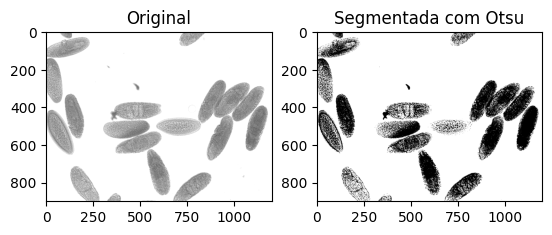

In [41]:
# Aplicação de Otsu sem suavização prévia
import cv2
import numpy as np
import matplotlib.pyplot as plt

def otsuThr(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    pixelsAmount = image.shape[0] * image.shape[1]

    bestThr = 0
    bestVariance = 0

    for threshold in range(256):

        # Divide o histograma em duas partes com base no limiar
        bgHist = np.sum(hist[:threshold])
        fgHist = np.sum(hist[threshold:])

        # Calcula as probabilidades do background e do objeto
        bgProb = bgHist / pixelsAmount
        fgProb = fgHist / pixelsAmount

        # Calcula as médias de intensidade do fundo e objeto
        bgMedia = np.sum(np.multiply(hist[:threshold+1].flatten(), np.arange(threshold+1))) / (bgHist + 1e-6)
        fgMedia = np.sum(np.multiply(hist[threshold+1:], np.arange(threshold+1, 256))) / (fgHist + 1e-6)

        # Calcula a variância intra-classe
        variance = bgProb * fgProb * ((bgMedia - fgMedia) ** 2)

        if variance >= bestVariance:
            bestVariance = variance
            bestThr = threshold

    segmentedImage = np.zeros((image.shape[0], image.shape[1]))
    
    # Aplica o limiar para segmentar a imagem
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if(image[i,j] <= bestThr):
                segmentedImage[i,j] = 0
            else:
                segmentedImage[i,j] = 255

    return segmentedImage

img1 = cv2.imread('insitu107595.jpg', cv2.IMREAD_GRAYSCALE)
imgOut = otsuThr(img1)

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.title("Segmentada com Otsu")
plt.imshow(imgOut, cmap="gray", vmin=0, vmax=255)

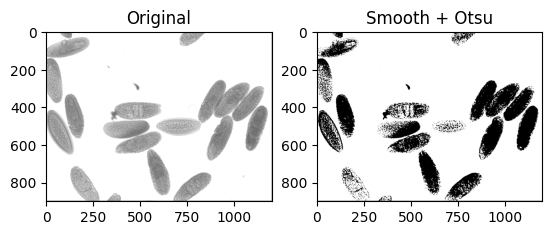

In [52]:
# Aplicação de segmentação com Otsu e suavização prévia

def smoothWithAvg(image, width, height):
    out = np.zeros((height,width))
    for i in range(1,height-1):
        for j in range(1,width-1):
            neighborsBlock = image[i-1:i+2, j-1:j+2]
            out[i,j] = np.sum(neighborsBlock)/9
    
    #gambiarra para resolver um erro do na função de cálculo de histograma do openCV
    for i in range(height):
        for j in range(width):
            image[i,j] = out[i,j]
    return image

img1 = cv2.imread('insitu107595.jpg', cv2.IMREAD_GRAYSCALE)
img1Smooth = smoothWithAvg(img1, img1.shape[1], img1.shape[0])
imgOut = otsuThr(img1Smooth)

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.title("Smooth + Otsu")
plt.imshow(imgOut, cmap="gray", vmin=0, vmax=255)

4)	Aplique o Otsu para a imagem HE.jpg, madrill.tiff e  Lenna.jpg (use antes a conversão da imagem para tons de cinza)

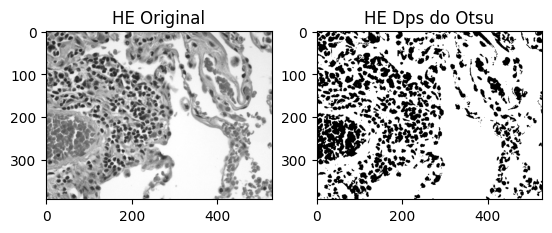

In [47]:
he = cv2.imread("HE.jpg", cv2.IMREAD_GRAYSCALE)

heOut = otsuThr(he)

plt.subplot(1,2,1)
plt.title("HE Original")
plt.imshow(he, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.title("HE Dps do Otsu")
plt.imshow(heOut, cmap='gray', vmin=0, vmax=255)

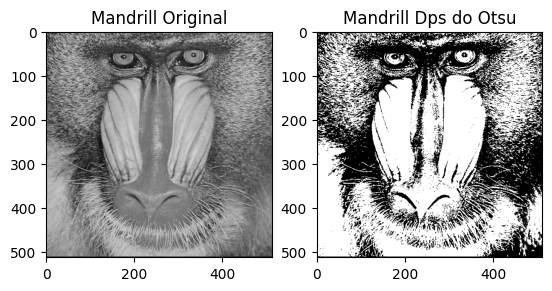

In [45]:
mandrill = cv2.imread("madrill.tiff", cv2.IMREAD_GRAYSCALE)

mandrillOut = otsuThr(mandrill)

plt.subplot(1,2,1)
plt.title("Mandrill Original")
plt.imshow(mandrill, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.title("Mandrill Dps do Otsu")
plt.imshow(mandrillOut, cmap='gray', vmin=0, vmax=255)

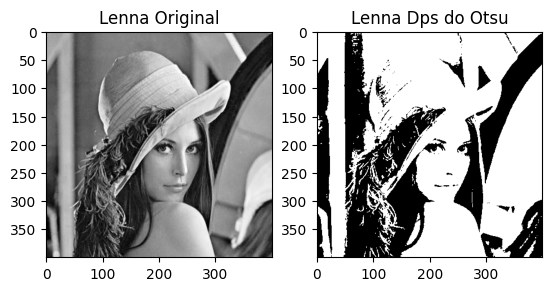

In [46]:
lenna = cv2.imread("Lenna.jpg", cv2.IMREAD_GRAYSCALE)

lennaOut = otsuThr(lenna)

plt.subplot(1,2,1)
plt.title("Lenna Original")
plt.imshow(lenna, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.title("Lenna Dps do Otsu")
plt.imshow(lennaOut, cmap='gray', vmin=0, vmax=255)